In [1]:
# Author: Afif Shomali
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Datasets/AirbnbData/Feature_Engineered_Airbnb.csv")

# Exploratory Data Analysis of Airbnb Dataset

Source: Inside Airbnb accessed at https://insideairbnb.com/get-the-data/ (Used New York City Datasets, used listings & reviews data)  
License : [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/)

The listings dataset being used is one that has combined multiple months of data from Inside Airbnb, addtionaly, data preprocessing & cleaning was performed, see `PreProcessingAirbnb.ipynb` to see what changes were made.
Some Features are not present in the orginal data and where Engineered using the other columns and reviews dataset, see `FeatureEngineeringAirbnb.ipynb` to see what was done.

General Overview of this EDA:
- Get a feel for the dataset and produce some visualizations for the final report & slides
- Check Engineered columns and see which ones of them to keep for the modeling step
- Run some statisical tests if needed 

In [2]:
# Create an estimated bookings per year column & occupancy rate, using an estimated number of times the listing was booked based on number of reviews
# Using similar methodolody to https://commissions.sfplanning.org/cpcpackets/2014-001033PCA.pdf,
# We use the estimate 5 night average stay length suggested by the report
# The report suggests to assume that 72% of people who book an airbnb leave a review, 
# however Inside Airbnb suggests that this percentange may be lower, so we assume that around 50% 
# So using the reviews per month column, we divide by 0.5 to get the number of times per month a listing was booked
# Then to calculate occupancy rate by dividing bookings per year by 365 and cliping those above 1

df["bookings_per_year"] = (df["reviews_per_month"] / 0.5) * 12
estimated_booked_nights_per_year = df["bookings_per_year"] * 5
df["estimated_ococcupancy_rate"] = (estimated_booked_nights_per_year) / (365)
df["estimated_ococcupancy_rate"] = df["estimated_ococcupancy_rate"].clip(upper=1)

In [ ]:
# Drop some more columns to make data managable
# Rationalle is that these columns are not adding much more value/are similar to another column already in the dataset
df.drop(columns=['minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'reviews_per_month', 'calculated_host_listings_count', "property_type"], 
       inplace=True)

## Getting a idea how that Data is distributed

In [95]:
# Around 42 thousand rows, 68 columns 
# 4 of these will be what we are trying to predict
# Some of the columns I've left in for the purposes of visualizations and may not be used for predictions
df.shape

(42430, 68)

### Looking at Potential Response Variables

Text(0.5, 0, 'Price in USD ($)')

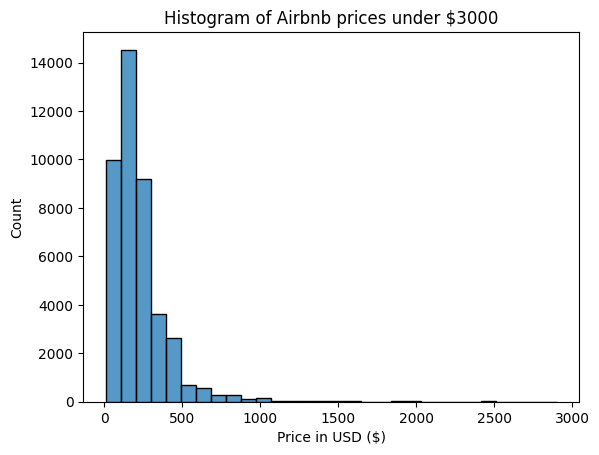

In [21]:
# Checking the distributions of variables we may try to predict such price, host_is_superhost, bookings_per_year or occupancy_rate

# Prices with extremely high prices removed
ax = sns.histplot(df[df["price"] < 3000]["price"], bins=30)
ax.set_title("Histogram of Airbnb prices under $3000")
ax.set_xlabel("Price in USD ($)")

We can see that the distributions of the prices of airbnb rentals is right skewed even when we remove all points with prices above 3000. We can use the logarithm of the price to get a less skewed distribution of values, if we end up trying to predict price, it will likely be better to use the log scaled price as our target, though for interpretability we would need to convert back to regular scale: 

Text(0.5, 0, 'Log Scale Price')

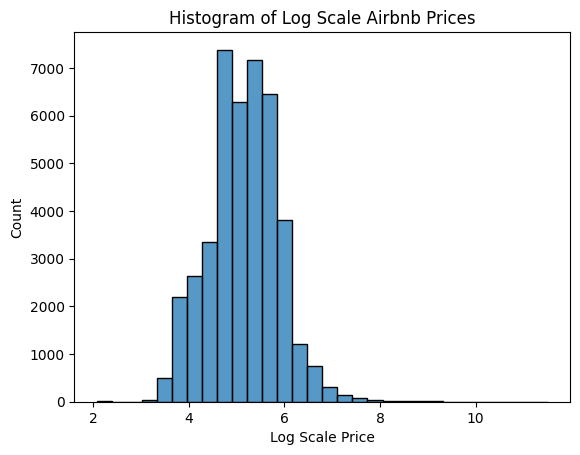

In [18]:
# Price in log scale
ax = sns.histplot(np.log(df["price"]), bins=30)
ax.set_title("Histogram of Log Scale Airbnb Prices")
ax.set_xlabel("Log Scale Price")

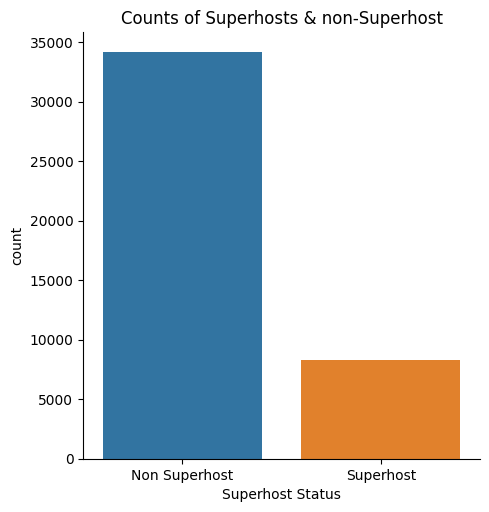

In [ ]:
# Super host distribution

ax = sns.catplot(x=df["host_is_superhost"], hue="host_is_superhost", data=df, kind="count", legend=False)
plt.title("Counts of Superhosts & non-Superhost")
ax.set_xticklabels(["Non Superhost", "Superhost"])
ax.set_xlabels("Superhost Status")

We see that this binary variable is unbalanced with their being more occurences of non superhosts compared to superhosts. This may potential cause issues when attempting to build a classification model for this variable, But I think we can work around this issue using based on some techniques that we have look over online, more details will be in the modeling notebook.

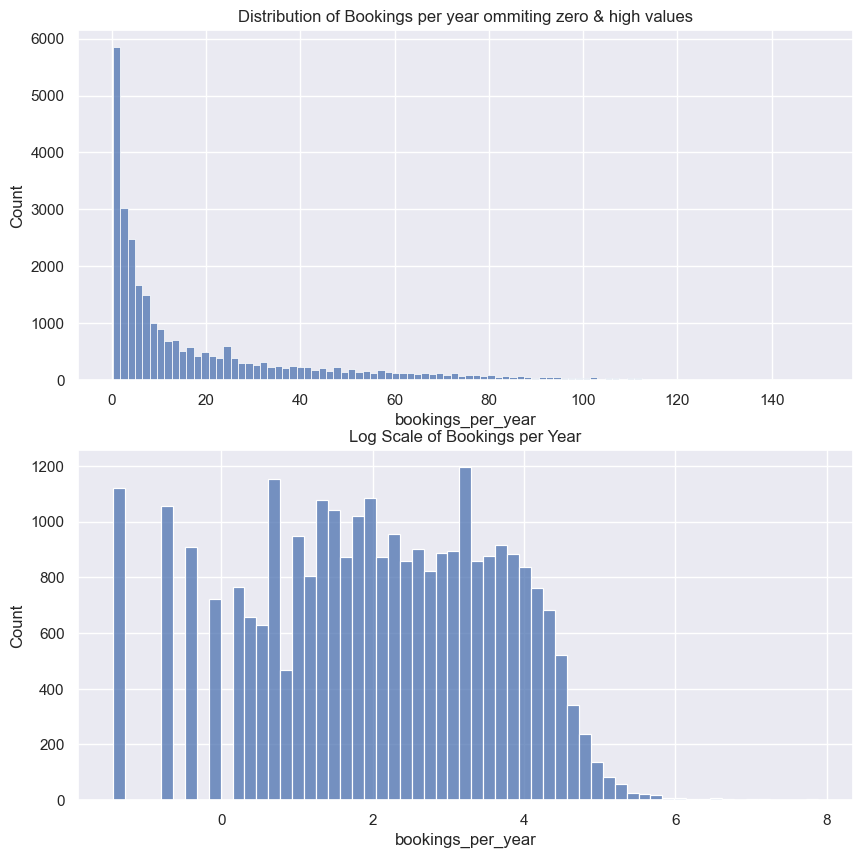

In [118]:
# Number of bookings per Year distribution, Omitting very large values and zero values to m

fig, axes = plt.subplots(2, figsize=(10, 10)) 

axes = axes.flatten()

for i in range(2):
    if i == 0:
        sns.histplot(df[(df["bookings_per_year"] < 150) & (df["bookings_per_year"] > 0)]["bookings_per_year"], ax=axes[i])
        axes[i].set_title("Distribution of Bookings per year ommiting zero & high values")
    else:
        sns.histplot(np.log(df[df["bookings_per_year"] > 0]["bookings_per_year"]), ax=axes[i])
        axes[i].set_title("Log Scale of Bookings per Year")

### Comparing Response Variables to Some Cateogrial Variables

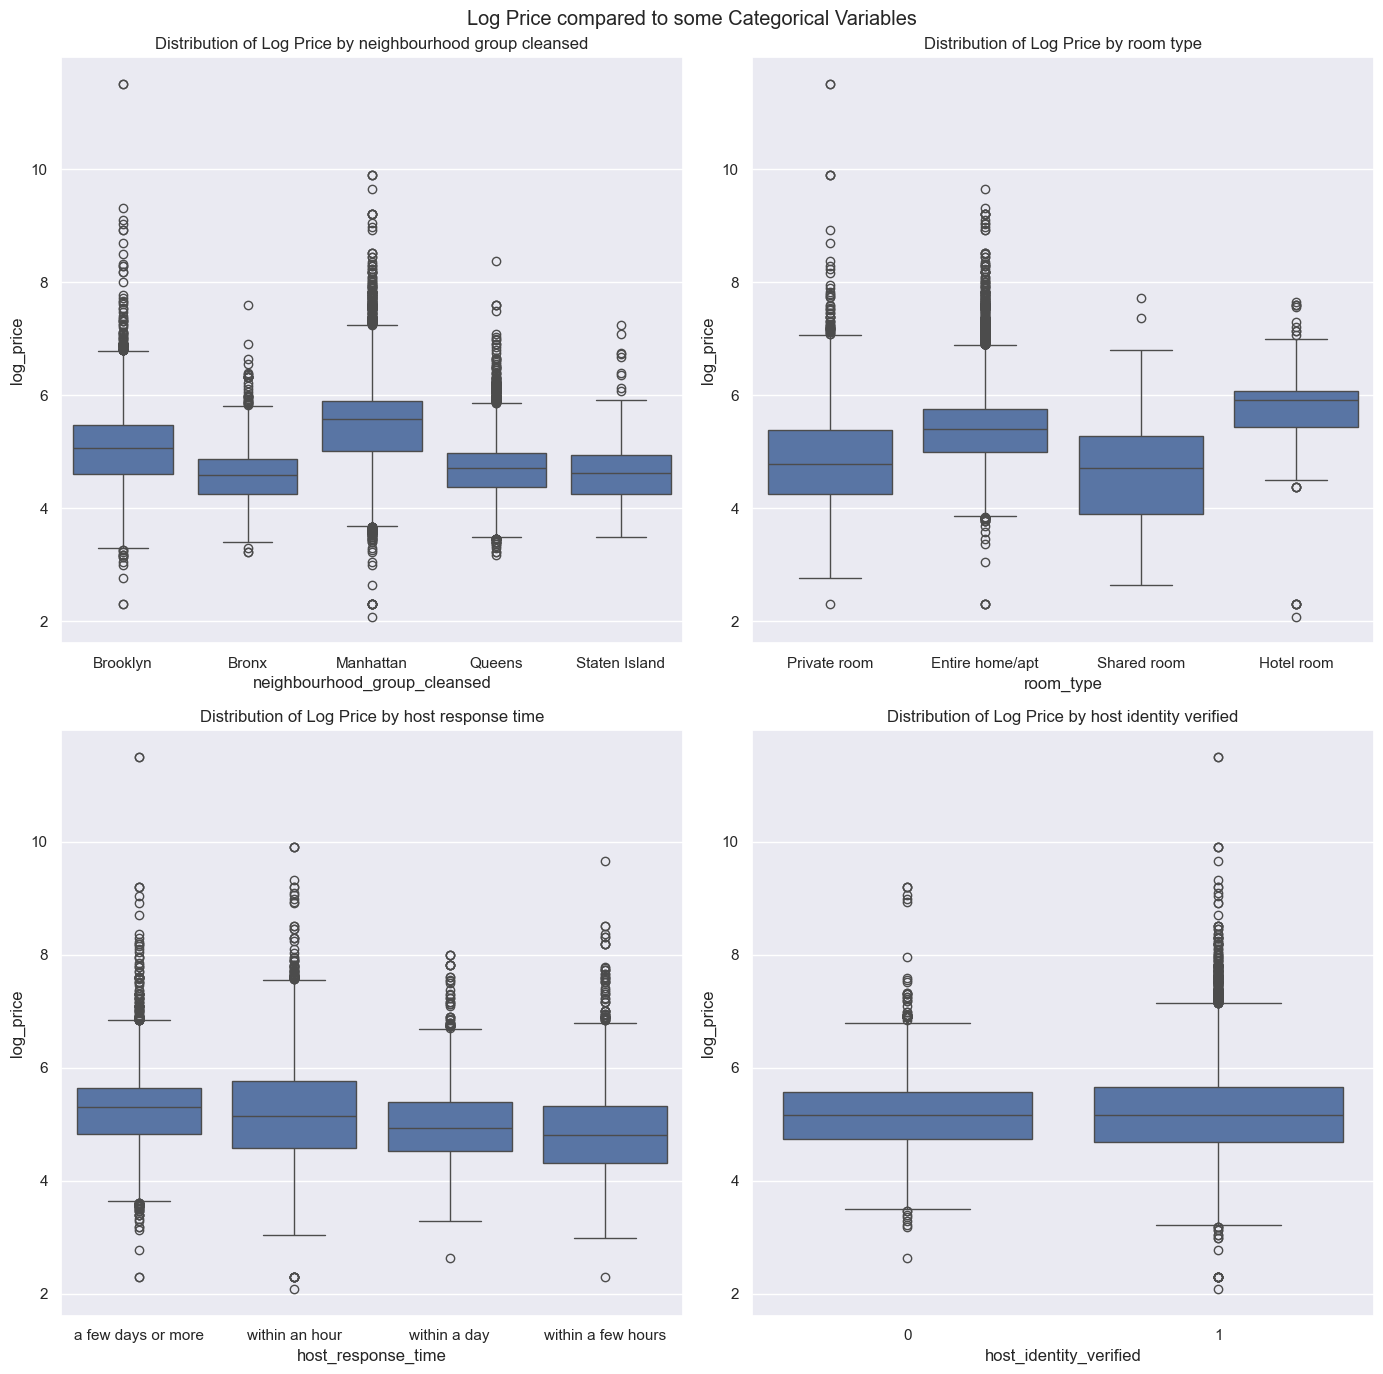

In [68]:
# Prices vs some categorical variables distribtuions:
# neighbourhood/bourough, room_type, host_response_time, host_identity_verified
categorical = ["neighbourhood_group_cleansed", "room_type", "host_response_time", "host_identity_verified"]
df["log_price"] = np.log(df["price"])

fig, axes = plt.subplots(2, 2, figsize=(14, 14)) 

axes = axes.flatten()

for i, col in enumerate(categorical):
    sns.boxplot(x=col, y="log_price", data=df, ax=axes[i])
    axes[i].set_title(f"Distribution of Log Price by {col.replace("_", " ")}")

fig.suptitle("Log Price compared to some Categorical Variables")   
plt.tight_layout()
# for col in categorical:
#     sns.catplot(x=col, y="log_price", data=df, kind="box", height=7, aspect=1)

We can see from these that the most visually significant differences in price come from the bourough/neighborhood group and room type variables while for the other categorical variables the distributions are pretty similar across levels of the variable.

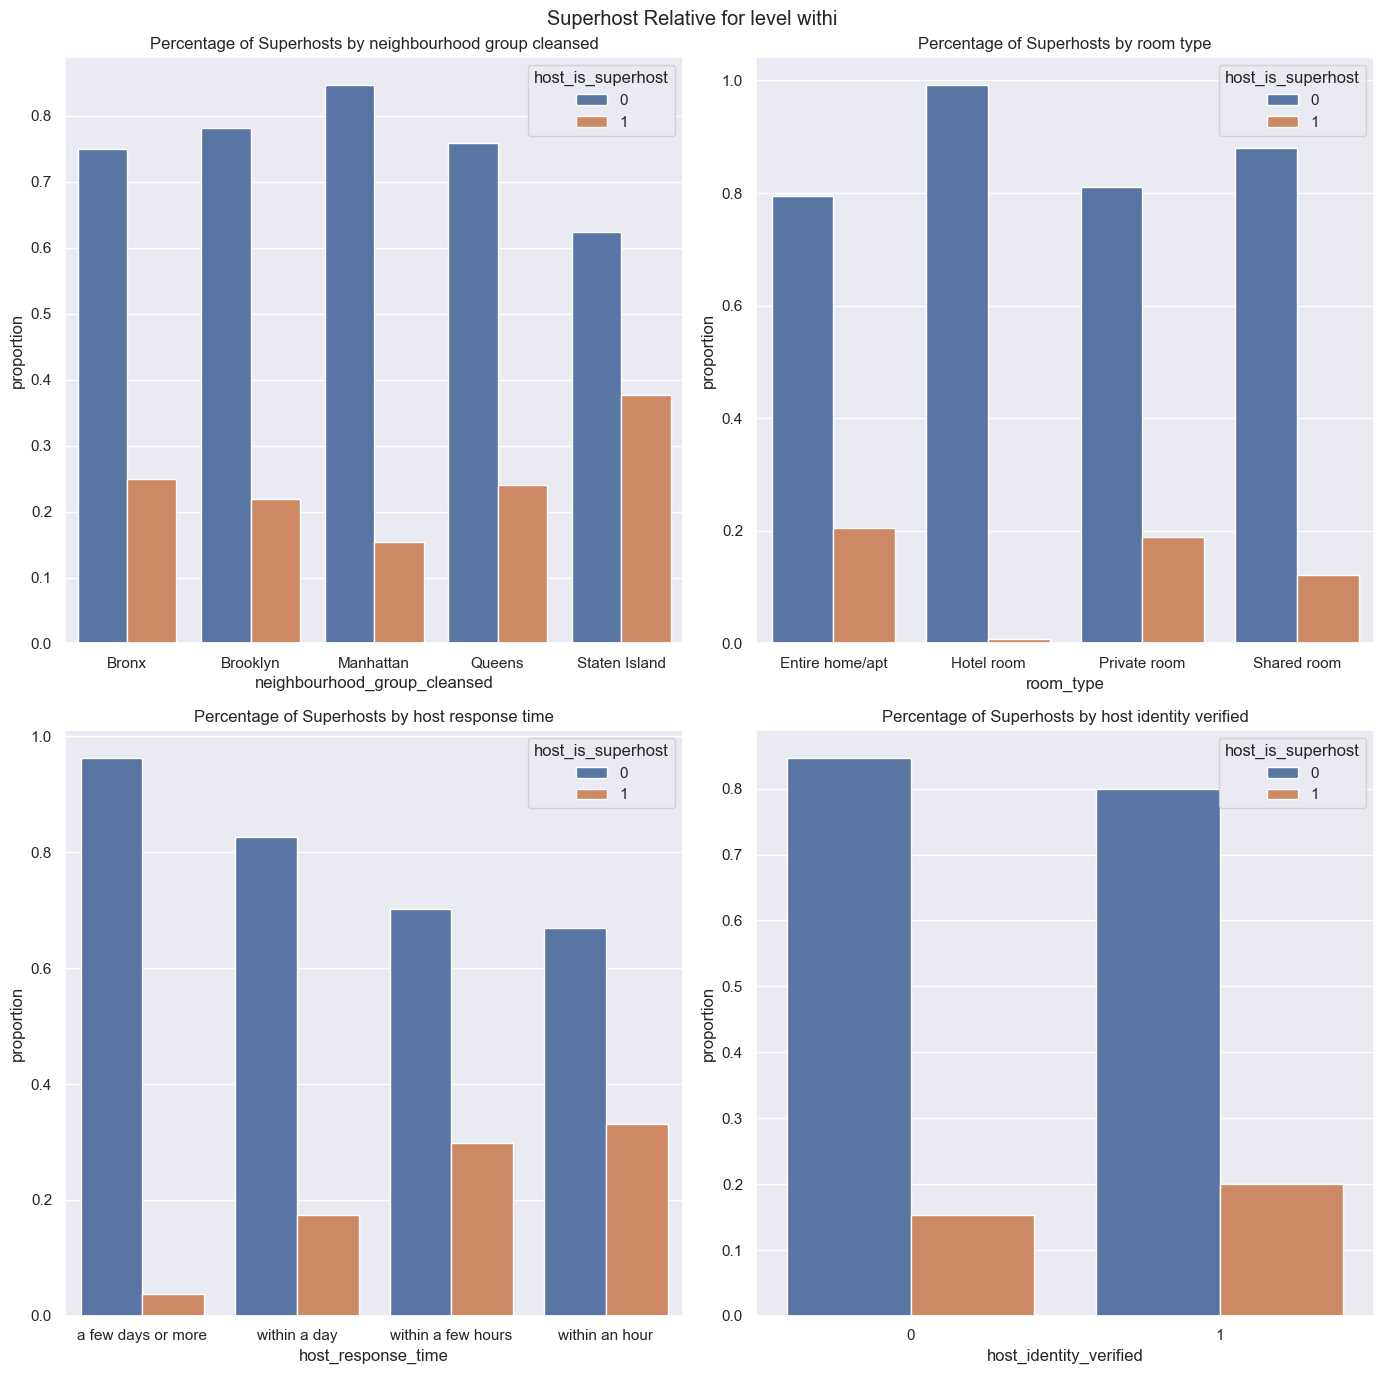

In [ ]:
# Super_host vs categorical variables: 
# neighbourhood/bourough, room_type, property_type, host_response_time or rate, host_identity_verified

fig, axes = plt.subplots(2, 2, figsize=(14, 14)) 

axes = axes.flatten()

for i, col in enumerate(categorical):
    prop_df = df.groupby([col, 'host_is_superhost']).size().reset_index(name="count")
    prop_df['proportion'] = prop_df.groupby(col)['count'].transform(lambda x: x / x.sum())

    sns.barplot(data=prop_df, x=col, y='proportion', hue='host_is_superhost', ax=axes[i])

    #sns.histplot(x=df[col], hue=df["host_is_superhost"], ax=axes[i], multiple="dodge", stat ='percent', shrink = 0.8, common_norm=True)
    axes[i].set_title(f"Percentage of Superhosts by {col.replace("_", " ")}")

fig.suptitle("Superhost Proportion for each level of Categorical Variable")   
plt.tight_layout()

I decided to plot the proportions of superhosts vs non superhosts for each level of a categorical variable so we can more easily compare across the levels incase they had a a different number of observations per level. Using this we can see that for bourough, Staten Island appears to have a higher proportion of superhosts compared to other bouroughs and Manhattan has a slighty lower proportion of superhosts while the rest have pretty similar levels.  
We see that hotel rooms have a really small proportion of superhosts its nearly zero.  
We see that as the host response time speeds up (e.g the host responds in a shorter period of time), the proportion of superhosts also rise. 
Finally we see that identity verfication sees a slight difference with idenity verified listings having a higher proportion of super hosts by a difference of about 5%, as in 20% of identity verified hosts are super hosts and 15% of non-identity verified hosts are superhosts.


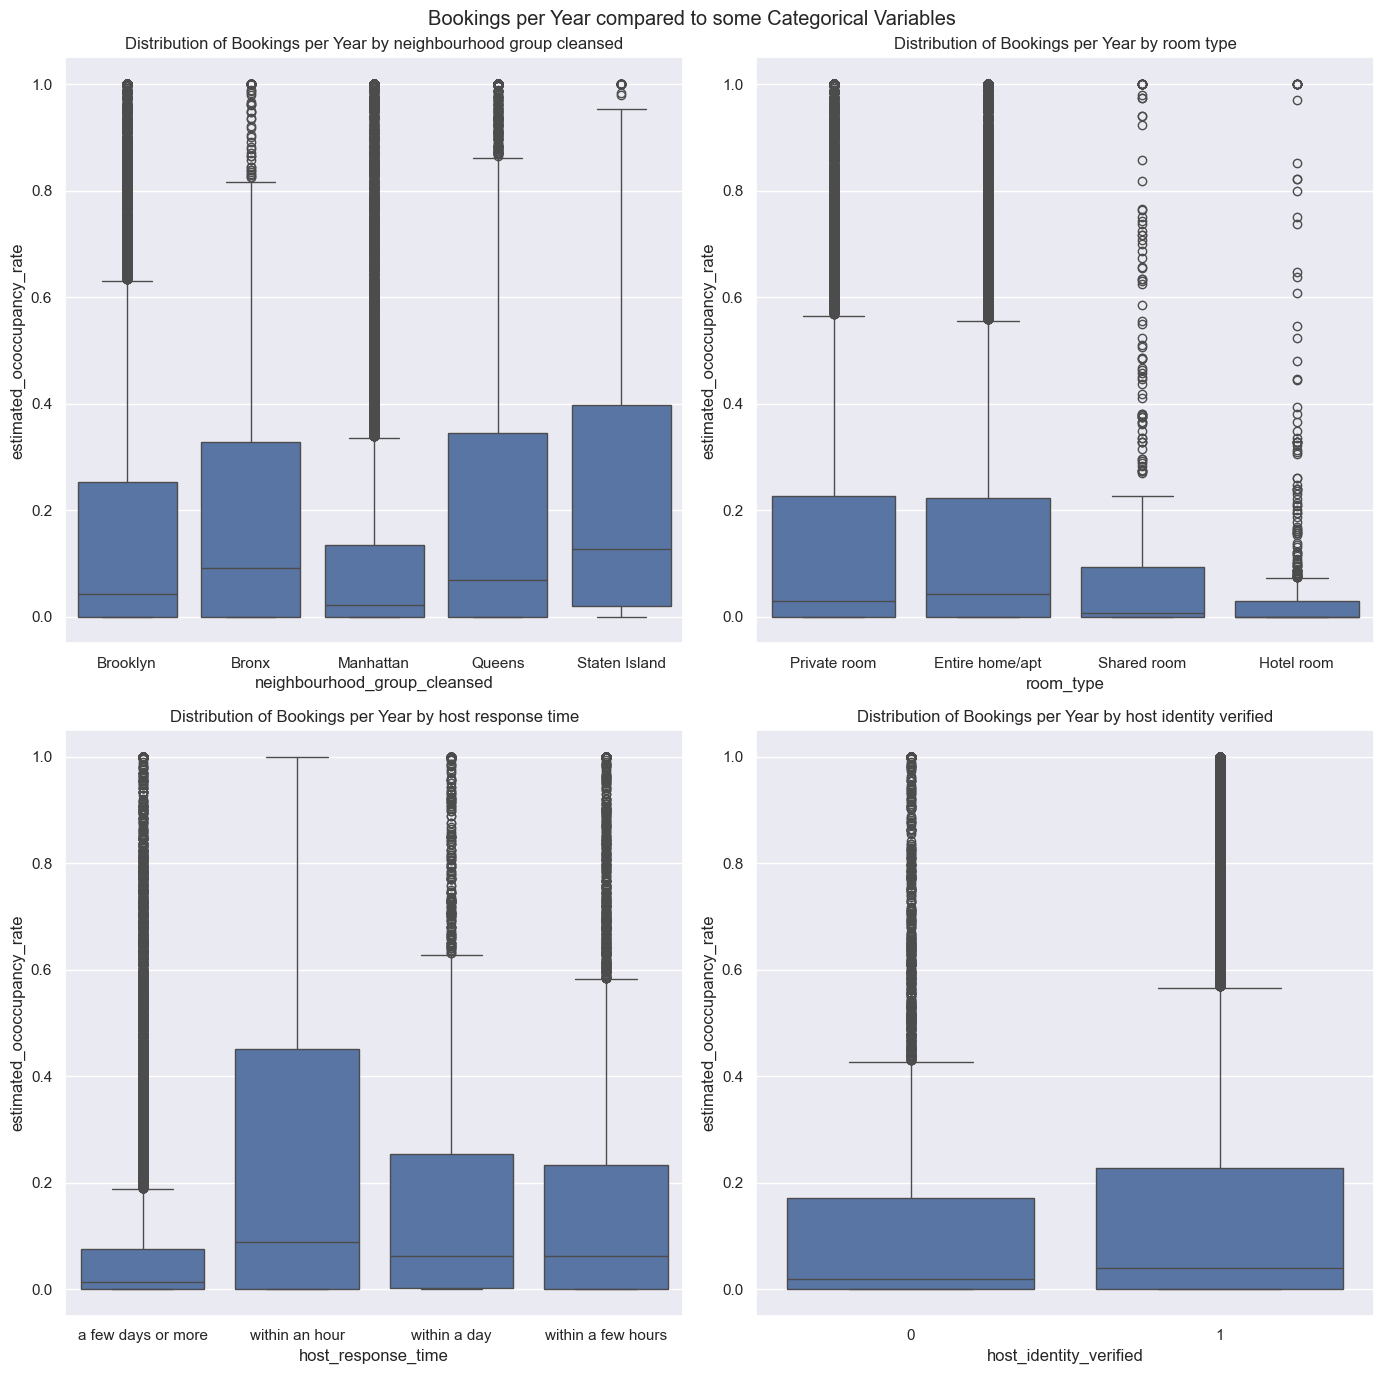

In [135]:
# Occupancy rate vs categorical variables:
# neighbourhood/bourough, room_type, property_type, host_response_time or rate, host_identity_verified
fig, axes = plt.subplots(2, 2, figsize=(14, 14)) 

axes = axes.flatten()

for i, col in enumerate(categorical):
    sns.boxplot(x=col, y="estimated_ococcupancy_rate", data=df, ax=axes[i])
    axes[i].set_title(f"Distribution of Bookings per Year by {col.replace("_", " ")}")

fig.suptitle("Bookings per Year compared to some Categorical Variables")   
plt.tight_layout()

From these boxplots we can see that manhattan has a much lower estimated occupancy rate and while Staten Island has a slighlty higher occupancy rate based on the median and Q3 locations.  

We see Private rooms and entire homes/apartment tend to have higher occupancy rates too.  
We see that hosts that respond faster also tend to have higher occupancy rates as seen by Q3 of the "within an hour" level of the variable.  
Finally for host verification we see that the distributions are pretty similar.

### Plotting Some more Interesting Details About the Data

Text(0.5, 1.0, 'Distribution of Room Types by Count')

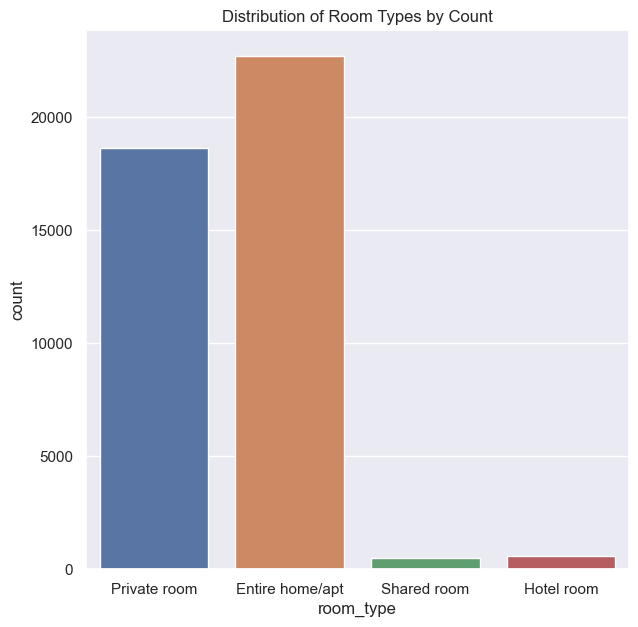

In [167]:
# Distrbution of Room types
sns.countplot(data=df, x="room_type", hue="room_type")
plt.title("Distribution of Room Types by Count")

Text(0.5, 0, 'Room Type')

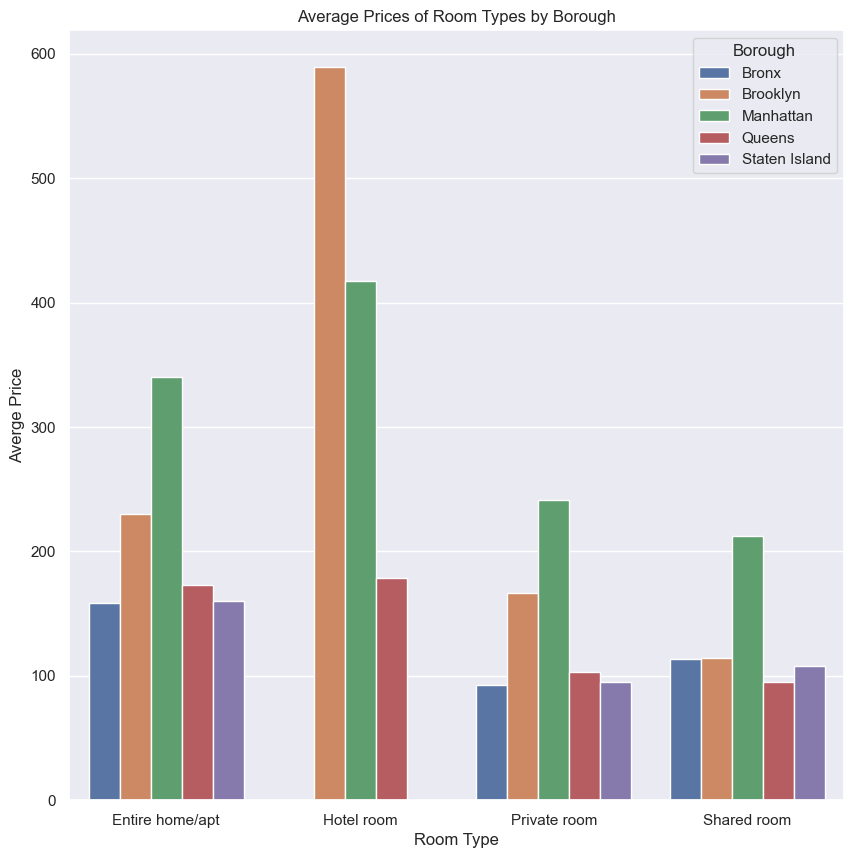

In [160]:
# Prices grouped by bourough then roomtype
# Used for Idea/Inspiration for this chart: https://www.kaggle.com/code/subhradeep88/airbnb-analysis-eda 
plt.figure(figsize=(10, 10))

brmt_df = df.groupby(["room_type", "neighbourhood_group_cleansed"])['price'].mean().reset_index()


sns.barplot(data=brmt_df, x="room_type", y="price", hue="neighbourhood_group_cleansed")
plt.legend(title="Borough")
plt.title("Average Prices of Room Types by Borough")
plt.ylabel("Averge Price")
plt.xlabel("Room Type")

In [ ]:
# See the acutal average price Numbers
pd.DataFrame(df.groupby(["room_type", "neighbourhood_group_cleansed"])['price'].mean().sort_values(ascending=True)).sort_values(by="room_type")

price
room_type       neighbourhood_group_cleansed            
Entire home/apt Staten Island                 160.437694
                Manhattan                     340.012096
                Brooklyn                      230.284887
                Queens                        172.941802
                Bronx                         158.850224
Hotel room      Queens                        179.003448
                Manhattan                     417.708454
                Brooklyn                      589.465362
Private room    Brooklyn                      166.810651
                Queens                        102.806213
                Manhattan                     241.184845
                Staten Island                  94.754174
                Bronx                          92.960907
Shared room     Bronx                         113.236927
                Staten Island                 107.958333
                Manhattan                     212.074159
                Queens                         95.091560
                Brooklyn                      114.521830

Text(0.5, 0.92, '3D scatter plot of Sentiment Analysis Scores')

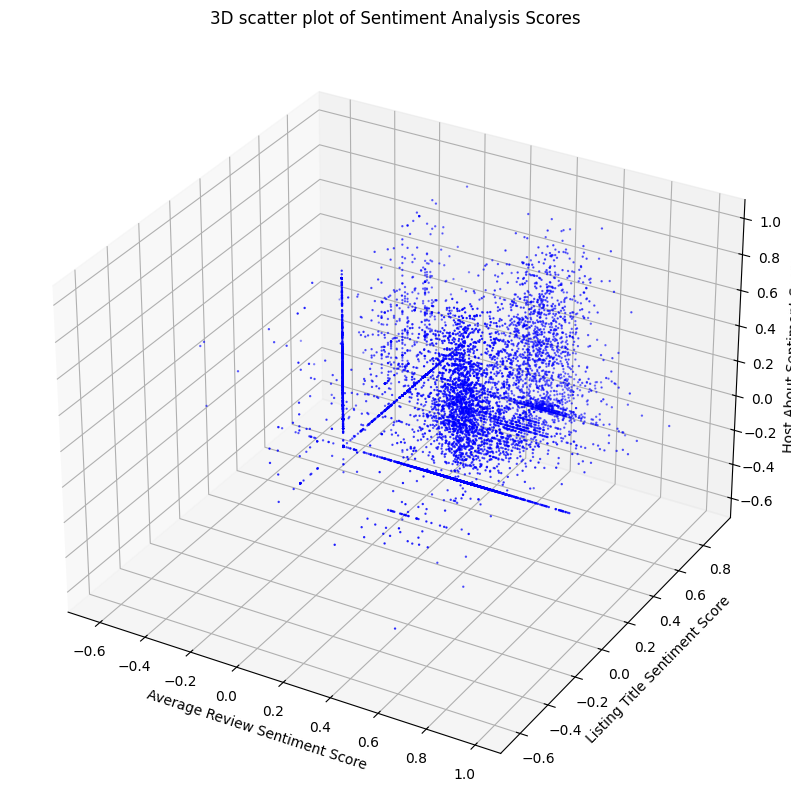

In [ ]:
# 3D Plot: Sentiment scores
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')


sample = df.sample(n=10000)
ax.scatter(sample["average_review_sentiment_score"], sample["title_sentiment_score"], sample['host_about_sentiment_score'], c='b', marker='o', s=0.5)  # Scatter plot with small points

# Set labels
ax.set_xlabel('Average Review Sentiment Score')
ax.set_ylabel('Listing Title Sentiment Score')
ax.set_zlabel('Host About Sentiment Score')

plt.title("3D scatter plot of Sample of Sentiment Analysis Scores")

c:\Users\Afif\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0.92, '3D scatter plot')

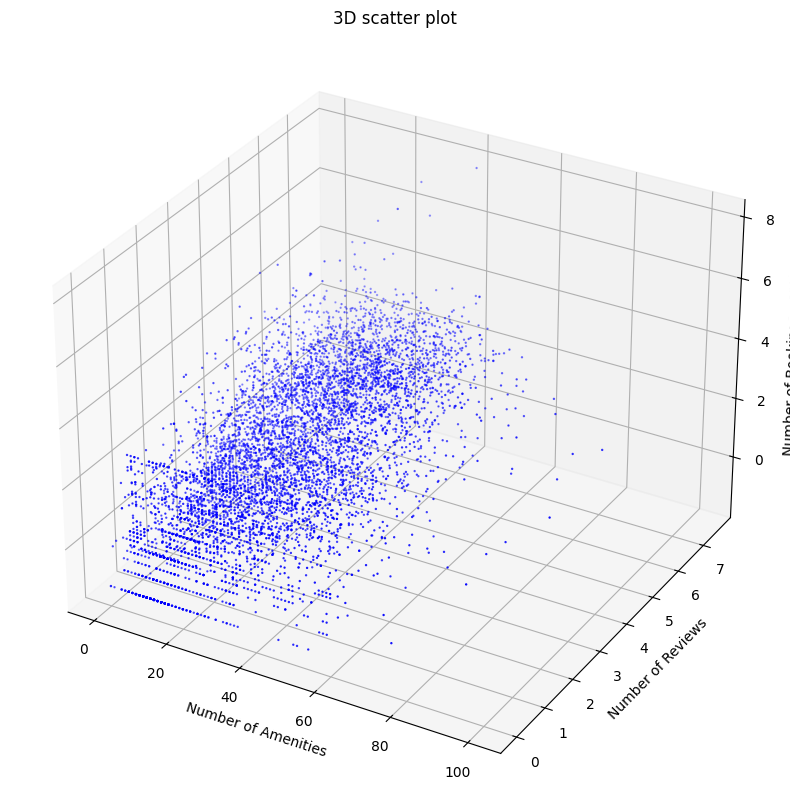

In [ ]:
# 3D Plot: amentities, reviews, bookings per year
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')


sample = df.sample(n=10000)
ax.scatter(sample["num_amenities"], np.log(sample["number_of_reviews"]), np.log(sample['bookings_per_year']), c='b', marker='o', s=0.5)  # Scatter plot with small points

# Set labels
ax.set_xlabel('Number of Amenities')
ax.set_ylabel('Log scaled Number of Reviews')
ax.set_zlabel('Log scaled Number of Bookings per Year')

plt.title("3D scatter plot")

In [170]:
# Potential Extras if there is time:
# Locations of listings on NYC map, with hue set to be review sentiment rating, super_host_status, prices, etc. 
df.columns

Index(['id', 'last_scraped', 'host_id', 'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights', 'has_availability',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'instant_bookable',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'num_host_ver

## Checking Correlations

In [ ]:
# Check correlations between some of the numeric columns

df[['host_is_superhost', 'log_price', 'bookings_per_year', 'average_review_sentiment_score',
       'description_FRES_score', 'title_sentiment_score',
       'host_about_sentiment_score', 'neighborhood_overview_score', 
       'num_amenities', 'num_host_verifications', 'number_of_reviews']].corr()

# num_host_verifications has very small, nearly zero correlations with 

,host_is_superhost,log_price,bookings_per_year,average_review_sentiment_score,description_FRES_score,title_sentiment_score,host_about_sentiment_score,neighborhood_overview_score,num_amenities,num_host_verifications,number_of_reviews
host_is_superhost,1.000000,-0.054348,0.216201,0.237708,0.002911,0.002146,0.050080,0.036437,0.352975,-0.001658,0.247601
log_price,-0.054348,1.000000,0.011855,-0.013251,-0.083187,-0.030648,0.027903,0.044304,0.074688,0.105121,-0.042442
bookings_per_year,0.216201,0.011855,1.000000,0.240852,-0.000191,0.000380,0.001238,0.002526,0.208036,-0.022059,0.603748
average_review_sentiment_score,0.237708,-0.013251,0.240852,1.000000,0.076453,0.082706,0.042901,0.132427,0.274624,0.039007,0.278270
description_FRES_score,0.002911,-0.083187,-0.000191,0.076453,1.000000,0.009118,-0.030817,0.097410,-0.030749,0.007002,0.029903
title_sentiment_score,0.002146,-0.030648,0.000380,0.082706,0.009118,1.000000,0.003719,0.034625,-0.004855,-0.025813,0.024191
host_about_sentiment_score,0.050080,0.027903,0.001238,0.042901,-0.030817,0.003719,1.000000,0.111765,0.165022,0.134095,0.089022
neighborhood_overview_score,0.036437,0.044304,0.002526,0.132427,0.097410,0.034625,0.111765,1.000000,0.126964,0.088867,0.110390
num_amenities,0.352975,0.074688,0.208036,0.274624,-0.030749,-0.004855,0.165022,0.126964,1.000000,0.086680,0.231630
num_host_verifications,-0.001658,0.105121,-0.022059,0.039007,0.007002,-0.025813,0.134095,0.088867,0.086680,1.000000,0.030983


In [ ]:
df[['host_is_superhost', 'log_price', 'bookings_per_year','review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']].corr()

# Drop all but review scores rating since the reviews scores are highly correlated with each other and the review score rating has small but still non zero correlation with superhost status & bookings per year

,host_is_superhost,log_price,bookings_per_year,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
host_is_superhost,1.000000,-0.054348,0.216201,0.248951,0.243498,0.254360,0.238653,0.240914,0.231620,0.245493
log_price,-0.054348,1.000000,0.011855,-0.029465,-0.030427,-0.026889,-0.034553,-0.031868,-0.018788,-0.032676
bookings_per_year,0.216201,0.011855,1.000000,0.261722,0.260709,0.269789,0.260564,0.260970,0.258717,0.262422
review_scores_rating,0.248951,-0.029465,0.261722,1.000000,0.994157,0.991351,0.991269,0.993046,0.987988,0.993078
review_scores_accuracy,0.243498,-0.030427,0.260709,0.994157,1.000000,0.989708,0.992178,0.992615,0.988112,0.992455
review_scores_cleanliness,0.254360,-0.026889,0.269789,0.991351,0.989708,1.000000,0.986668,0.986715,0.983217,0.987651
review_scores_checkin,0.238653,-0.034553,0.260564,0.991269,0.992178,0.986668,1.000000,0.993294,0.989442,0.989149
review_scores_communication,0.240914,-0.031868,0.260970,0.993046,0.992615,0.986715,0.993294,1.000000,0.988000,0.990199
review_scores_location,0.231620,-0.018788,0.258717,0.987988,0.988112,0.983217,0.989442,0.988000,1.000000,0.987008
review_scores_value,0.245493,-0.032676,0.262422,0.993078,0.992455,0.987651,0.989149,0.990199,0.987008,1.000000


In [ ]:
df[['host_is_superhost', 'log_price', 'bookings_per_year','host_phone_verified', 'host_email_verified',
       'host_work_email_verified', 'num_amenities', 'kitchen', 'oven', 'stove',
       'refrigerator', 'air conditioning', 'sound system', 'wifi', 'tv',
       'parking', 'gym/exercise equipment', 'pool', 'hygiene products',
       'laundry', 'coffee', 'view']].corr()

# Dropped Verification columns since we already have a is verified column and dropped a few amenties with close to zero correlation with all responses

,host_is_superhost,log_price,bookings_per_year,host_phone_verified,host_email_verified,host_work_email_verified,num_amenities,kitchen,oven,stove,...,sound system,wifi,tv,parking,gym/exercise equipment,pool,hygiene products,laundry,coffee,view
host_is_superhost,1.000000,-0.054348,0.216201,0.023944,0.017069,-0.020754,0.352975,0.031258,0.204898,0.250639,...,0.075873,0.054518,0.062472,0.245369,-0.025831,-0.007820,0.153965,0.143827,0.273974,0.158555
log_price,-0.054348,1.000000,0.011855,-0.019592,0.021744,0.131091,0.074688,-0.068029,-0.020611,-0.078765,...,0.098874,-0.011970,0.146551,-0.062011,0.246343,0.102893,0.228536,0.144449,0.092548,0.044124
bookings_per_year,0.216201,0.011855,1.000000,0.013235,0.008695,-0.040395,0.208036,-0.097801,0.069235,0.113646,...,0.026096,0.039018,0.048678,0.164388,-0.027240,-0.024833,0.167805,0.099251,0.176908,0.064098
host_phone_verified,0.023944,-0.019592,0.013235,1.000000,0.037622,0.005898,0.034530,-0.009887,0.022318,0.021730,...,0.012555,0.009662,0.010805,0.023291,0.011272,0.003589,-0.006813,0.003378,0.029238,0.012283
host_email_verified,0.017069,0.021744,0.008695,0.037622,1.000000,0.096651,0.046710,-0.002892,0.051542,0.024005,...,0.028099,0.035744,-0.019961,0.023982,0.030978,-0.008288,0.052791,0.044899,0.042889,0.020467
host_work_email_verified,-0.020754,0.131091,-0.040395,0.005898,0.096651,1.000000,0.075449,0.053824,0.093667,-0.010294,...,0.012725,0.022175,0.048129,-0.042821,0.145253,0.039511,0.113169,0.087413,0.109733,0.020490
num_amenities,0.352975,0.074688,0.208036,0.034530,0.046710,0.075449,1.000000,0.113311,0.654170,0.670037,...,0.371369,0.140379,0.247499,0.562765,0.204617,0.105520,0.487269,0.439025,0.703419,0.347055
kitchen,0.031258,-0.068029,-0.097801,-0.009887,-0.002892,0.053824,0.113311,1.000000,0.260492,0.299929,...,-0.010360,0.128039,-0.015437,-0.013712,-0.123287,0.021761,-0.072228,0.060545,0.090606,0.050027
oven,0.204898,-0.020611,0.069235,0.022318,0.051542,0.093667,0.654170,0.260492,1.000000,0.774882,...,0.160610,0.094841,0.152303,0.350315,0.049524,0.033198,0.221587,0.248559,0.552978,0.160808
stove,0.250639,-0.078765,0.113646,0.021730,0.024005,-0.010294,0.670037,0.299929,0.774882,1.000000,...,0.166009,0.087413,0.114975,0.413777,-0.022719,0.010179,0.223676,0.246746,0.546196,0.181790


In [202]:
# Dropping columns that are low correlation or multi colinear (reviews scores, host_total_listings)
# Also dropping columns that were only there for EDA/visulizations
df.drop(columns=['review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', "num_host_verifications", 'last_scraped',
       'host_location', 'host_neighbourhood', 'latitude', 'longitude',
       'property_type', 'host_phone_verified', 'host_email_verified',
       'host_work_email_verified', 'sound system', 'wifi', 'kitchen'], inplace=True)

df.to_csv("Datasets/AirbnbData/ModelingData.csv", index=False)

df.shape

# We get down to around 50 columns, 4 potential response variables, 2 ID variables and the rest are potential predictors 

(42430, 50)

# 